# Introduction

This notebook contains code used to generate the timestamped OrphaNet dataset used in our analysis. It leverages XML files downloaded from [OrphaData](http://www.orphadata.org/cgi-bin/index.php), which provides aggregated data from the OrphaNet program and is updated monthly. All the files produced as output from this notebook -- as well as those used as input to it -- can be found in the `orphanet` subfolder of our data repository on the Harvard Dataverse (updated link to be found in the GitHub Readme).

In [2]:
from pathlib import Path
import pandas as pd
import sys
from collections import OrderedDict
import xml.etree.ElementTree as ET
from matplotlib import pyplot
from upsetplot import from_contents, from_memberships
from upsetplot import plot as plot_upset
sys.path.insert(0, '../') # add config to path
import config

ORPHANET_FLAT_PATH = config.ORPHANET_PATH / 'intermediate_files'
ORPHANET_RAW_PATH = config.ORPHANET_PATH / 'raw_files_2019_10'

ModuleNotFoundError: No module named 'upsetplot'

# Process OrphaData XML files

This section of the notebook reads the XML files downloaded from Orphadata into Pandas. Note that because the OrphaData XML format has changed slightly over time, this code may need to be adjusted to work on newer versions of these files.

## Read in phenotypes file



In [1]:
tree = ET.parse(str(ORPHANET_RAW_PATH / 'phenotypes_rare_disorders_en_product4_HPO.xml'))
root = tree.getroot()
disorderlist_phenos = root[1]

hpo_list = []
for disorder in disorderlist_phenos:
    disorder_orphan = disorder.find("OrphaNumber").text
    disorder_name = disorder.find("Name").text
    for child in disorder.find("HPODisorderAssociationList"):
        child_hpo = child.find("HPO")
        hpo_id = child_hpo.find("HPOId").text
        hpo_string = child_hpo.find("HPOTerm").text
        hpo_freq = child.find("HPOFrequency").find("Name").text
        hpo_list.append(OrderedDict([
            ("OrphaNumber", disorder_orphan),
            ("Disorder_Name", disorder_name),
            ("HPO_ID", hpo_id),
            ("HPO_String", hpo_string),
            ("HPO_Freq", hpo_freq)]))
disease_hpo_df = pd.DataFrame(hpo_list)
disease_hpo_df.head(10)

NameError: name 'ET' is not defined

Disease counts and simple histogram of phenotype frequencies, for reference:

In [3]:
print("Unique diseases w/ HPOS: ", len(set(disease_hpo_df.OrphaNumber)))

Unique diseases w/ HPOS:  3702


In [4]:
disease_hpo_df.HPO_Freq.value_counts()

Frequent (79-30%)         28349
Occasional (29-5%)        25978
Very frequent (99-80%)    25653
Very rare (<4-1%)          2600
Obligate (100%)             538
Excluded (0%)               447
Name: HPO_Freq, dtype: int64

## Read in Genes file 


In [5]:
tree = ET.parse(str(ORPHANET_RAW_PATH / 'genes_rare_diseases_en_product6.xml'))
root = tree.getroot()
disorderlist_genes = root[1]

gene_list = []
for disorder in disorderlist_genes:
    disorder_orphan = disorder.find("OrphaNumber").text
    disorder_name = disorder.find("Name").text
    for child in disorder.find("DisorderGeneAssociationList"):
        child_gene = child.find("Gene")
        gene_symbol = child_gene.find("Symbol").text
        gene_synonyms = "|".join([x.text
                                  for x in child_gene.find("SynonymList")])
        external_refs = "|".join([":".join([x.find("Source").text, x.find("Reference").text])
                                  for x in child_gene.find("ExternalReferenceList")])
        association_type = child.find("DisorderGeneAssociationType").find("Name").text
        association_status = child.find("DisorderGeneAssociationStatus").find("Name").text
        gene_list.append(OrderedDict([
            ("OrphaNumber", disorder_orphan),
            ("Disorder_Name", disorder_name),
            ("Gene_Symbol", gene_symbol),
            ("Association_Type", association_type),
            ("Association_Status", association_status),
            ("Gene_Synonyms", gene_synonyms),
            ("Gene_External_Refs", external_refs)
        ]))
disorder_gene_df = pd.DataFrame(gene_list)
print(disorder_gene_df.shape)
disorder_gene_df.head(5)

(7552, 7)


,OrphaNumber,Disorder_Name,Gene_Symbol,Association_Type,Association_Status,Gene_Synonyms,Gene_External_Refs
0,166024,"Multiple epiphyseal dysplasia, Al-Gazali type",KIF7,Disease-causing germline mutation(s) in,Assessed,JBTS12,Ensembl:ENSG00000166813|Genatlas:KIF7|HGNC:304...
1,93,Aspartylglucosaminuria,AGA,Disease-causing germline mutation(s) in,Assessed,ASRG|N(4)-(beta-N-acetylglucosaminyl)-L-aspara...,Reactome:P20933|Ensembl:ENSG00000038002|Genatl...
2,166035,Brachydactyly-short stature-retinitis pigmento...,CWC27,Disease-causing germline mutation(s) in,Assessed,NY-CO-10|SDCCAG-10,
3,585,Multiple sulfatase deficiency,SUMF1,Disease-causing germline mutation(s) in,Assessed,FGE|UNQ3037,Ensembl:ENSG00000144455|Genatlas:SUMF1|HGNC:20...
4,118,Beta-mannosidosis,MANBA,Disease-causing germline mutation(s) in,Assessed,beta-mannosidase A,Reactome:O00462|Genatlas:MANBA|HGNC:6831|OMIM:...


Because orphanet provides annotation of these gene-disease associations, we also want the option of limiting ourselves to those genes that have been annotated as playing a causal role:

In [6]:
causal_assocation_types = ["Disease-causing germline mutation(s) in",
                           "Disease-causing germline mutation(s) (loss of function) in",
                           "Disease-causing germline mutation(s) (gain of function) in",
                           "Disease-causing somatic mutation(s) in"
                          ]
disorder_gene_df_causal = disorder_gene_df.query("Association_Type in @causal_assocation_types")

disorder_gene_df_causal = disorder_gene_df_causal.query("Association_Status == 'Assessed'")
disorder_gene_df_causal.drop_duplicates()
print("Unique diseases w/ Causal Genes: ", len(set(disorder_gene_df_causal.OrphaNumber)))

Unique diseases w/ Causal Genes:  3410


## Read in Natural History file 

This file contains information about the natural history of dieases. We will use it, in particular, to look at the age of onset of the disease.

Unique age entries in their file:
['Adolescent',
 'Adult',
 'All ages',
 'Antenatal',
 'Childhood',
 'Elderly',
 'Infancy',
 'Neonatal']
 }

In [7]:
tree = ET.parse(str(ORPHANET_RAW_PATH / 'natural_history_en_product9_ages.xml'))
root = tree.getroot()
disorderlist_nat_hist = root[1]

nat_hist_list = []
debug_disorder = None
for disorder in disorderlist_nat_hist:
    disorder_orphan = disorder.find("OrphaNumber").text
    disorder_name = disorder.find("Name").text
    disorder_type = disorder.find("DisorderType").find("Name").text
    average_age_onset = "|".join([x.find("Name").text
                                  for x in disorder.find("AverageAgeOfOnsetList")]) 
    
    onset_neonatal = ('All ages' in average_age_onset) or \
                    ('Antenatal' in average_age_onset) or ('Neonatal' in average_age_onset)
    onset_infant = ('All ages' in average_age_onset) or ('Infancy' in average_age_onset)
    onset_child = ('All ages' in average_age_onset) or ('Childhood' in average_age_onset)
    onset_adolescent = ('All ages' in average_age_onset) or ('Adolescent' in average_age_onset)
    onset_adult = ('All ages' in average_age_onset) or ('Adult' in average_age_onset)
    onset_elderly = ('All ages' in average_age_onset) or ('Elderly' in average_age_onset)
    
    average_age_death = "|".join([x.find("Name").text
                                  for x in disorder.find("AverageAgeOfDeathList")])
    inheritence_types = "|".join([x.find("Name").text
                                  for x in disorder.find("TypeOfInheritanceList")])
    nat_hist_list.append(OrderedDict([
        ("OrphaNumber", disorder_orphan),
        ("Disorder_Name", disorder_name),
        ("Onset_Infant", onset_infant),
        ("Onset_Child", onset_child),
        ("Onset_Adolescent", onset_adolescent),
        ("Onset_Adult", onset_adult),
        ("Onset_Elderly", onset_elderly),
        ("Disorder_Type", disorder_type),
        ("Average_Age_Onset", average_age_onset),
        ("Average_Age_Death", average_age_death),
        ("Inheritence_Types", inheritence_types)
        ]))
nat_hist_df = pd.DataFrame(nat_hist_list)
nat_hist_df = nat_hist_df.query("Disorder_Type != 'Category'")
nat_hist_df.head(5)

,OrphaNumber,Disorder_Name,Onset_Infant,Onset_Child,Onset_Adolescent,Onset_Adult,Onset_Elderly,Disorder_Type,Average_Age_Onset,Average_Age_Death,Inheritence_Types
0,166024,"Multiple epiphyseal dysplasia, Al-Gazali type",True,False,False,False,False,Disease,Infancy|Neonatal,,Autosomal recessive
1,58,Alexander disease,True,True,True,True,True,Disease,All ages,any age,Autosomal dominant
2,166032,"Multiple epiphyseal dysplasia, with miniepiphyses",True,True,False,False,False,Disease,Childhood|Infancy,No data available,
3,61,Alpha-mannosidosis,True,True,False,False,False,Disease,Childhood|Infancy|Neonatal,any age,Autosomal recessive
4,166029,"Multiple epiphyseal dysplasia, with severe pro...",False,True,False,False,False,Disease,Childhood,No data available,


In [8]:
print("Unique diseases w/ Natural History: ", len(set(nat_hist_df.OrphaNumber)))

Unique diseases w/ Natural History:  7577


## Read in "Linearization" (Categorization) file 

The linearization file provides systems-based categorizations of various diseases, which come in handy for various sub-group analyses.

In [9]:
tree = ET.parse(str(ORPHANET_RAW_PATH / 'linearization_of_disorders_en_product7.xml'))
root = tree.getroot()
disorderlist_linear = root[1]


linear_list = []
linear_list_cat = []
debug_disorder = None
for disorder in disorderlist_linear:
    disorder_orphan = disorder.find("OrphaNumber").text
    disorder_name = disorder.find("Name").text
    for child in disorder.find("DisorderDisorderAssociationList"):
        disorder1 = child.find("Disorder1")
        if "cycle" in disorder1.attrib:
            disorder1_orphan = disorder_orphan
            disorder1_name = disorder_name
        else:
            disorder1_orphan = disorder1.find("OrphaNumber").text
            disorder1_name = disorder1.find("Name").text
        disorder2 = child.find("Disorder2")
        if "cycle" in disorder2.attrib:
            disorder2_orphan = disorder_orphan
            disorder2_name = disorder_name
        else:
            disorder2_orphan = disorder2.find("OrphaNumber").text
            disorder2_name = disorder2.find("Name").text
        association_type = child.find("DisorderDisorderAssociationType").find("Name").text
        linear_list.append(OrderedDict([
            ("OrphaNumber1", disorder1_orphan),
            ("OrphaNumber2", disorder2_orphan),
            ("Disorder_Name1", disorder1_name),
            ("Disorder_Name2", disorder2_name),
            ("Assocation_Type", association_type)
            ]))
        linear_list_cat.append(OrderedDict([
            ("OrphaNumber", disorder2_orphan),
            ("Disorder_Name", disorder2_name),
            ("Category", disorder1_name),
            ]))
        
linear_df = pd.DataFrame(linear_list)

linear_cat_df = pd.DataFrame(linear_list_cat).drop_duplicates()
linear_cat_df.head(10)

,OrphaNumber,Disorder_Name,Category
0,166024,"Multiple epiphyseal dysplasia, Al-Gazali type",Rare bone disease
1,58,Alexander disease,Rare neurologic disease
2,166032,"Multiple epiphyseal dysplasia, with miniepiphyses",Rare bone disease
3,61,Alpha-mannosidosis,Rare inborn errors of metabolism
4,166029,"Multiple epiphyseal dysplasia, with severe pro...",Rare bone disease
5,166038,"Metaphyseal chondrodysplasia, Kaitila type",Rare bone disease
6,93,Aspartylglucosaminuria,Rare inborn errors of metabolism
7,166035,Brachydactyly-short stature-retinitis pigmento...,Rare bone disease
8,585,Multiple sulfatase deficiency,Rare inborn errors of metabolism
9,118,Beta-mannosidosis,Rare inborn errors of metabolism


Simple histogram of disease counts by category:

In [10]:
linear_cat_df.Category.value_counts()

Rare developmental defect during embryogenesis          2256
Rare neurologic disease                                 1140
Rare neoplastic disease                                  546
Rare inborn errors of metabolism                         512
Rare skin disease                                        437
Rare bone disease                                        385
Rare ophthalmic disorder                                 251
Rare endocrine disease                                   238
Rare hematologic disease                                 206
Rare systemic or rheumatologic disease                   192
Rare infectious disease                                  176
Rare immune disease                                      176
Rare renal disease                                       135
Rare gastroenterologic disease                            87
Rare respiratory disease                                  75
Rare hepatic disease                                      68
Rare otorhinolaryngologi

In [11]:
print("Unique diseases w/ Linearization: ", len(set(linear_cat_df.OrphaNumber)))

Unique diseases w/ Linearization:  7139


## Read in "Cross Reference"

Orphanet also provides cross-references of their OrphaNet identifiers to different ontologies such as ICD, UMLS, OMIM, etc., which is information we would like to be able to use when performing analysis such as linking with claims data.

In [12]:
tree = ET.parse(str(ORPHANET_RAW_PATH / 'rare_disease_crossref_en_product1.xml'))
root = tree.getroot()
disorderlist_cross = root[1]

rel_list = []
for disorder in disorderlist_cross:
    disorder_orphan = disorder.find("OrphaNumber").text
    disorder_name = disorder.find("Name").text
    disorder_synonyms = "|".join([x.text
                                  for x in disorder.find("SynonymList")])
    for child in disorder.find("ExternalReferenceList"):
        external_source = child.find("Source").text
        external_id = child.find("Reference").text
        external_mapping_rel = child.find("DisorderMappingRelation").find("Name").text
        external_mapping_status = child.find("DisorderMappingValidationStatus").find("Name").text
        rel_list.append(OrderedDict([
            ("OrphaNumber", disorder_orphan),
            ("Disorder_Name", disorder_name),
            ("External_Source", external_source),
            ("External_ID", external_id),
            ("External_Mapping_Rel", external_mapping_rel),
            ("External_Mapping_Status", external_mapping_status),
            ("Disorder_Synonyms", disorder_synonyms)
        ]))
rel_df = pd.DataFrame(rel_list)
rel_df = rel_df.query("External_Mapping_Status == 'Validated'")
rel_df.head(5)

,OrphaNumber,Disorder_Name,External_Source,External_ID,External_Mapping_Rel,External_Mapping_Status,Disorder_Synonyms
0,166024,"Multiple epiphyseal dysplasia, Al-Gazali type",ICD-10,Q77.3,NTBT (narrower term maps to a broader term),Validated,Multiple epiphyseal dysplasia-macrocephaly-dis...
1,166024,"Multiple epiphyseal dysplasia, Al-Gazali type",OMIM,607131,E (exact mapping (the terms and the concepts a...,Validated,Multiple epiphyseal dysplasia-macrocephaly-dis...
2,166024,"Multiple epiphyseal dysplasia, Al-Gazali type",UMLS,C1846722,E (exact mapping (the terms and the concepts a...,Validated,Multiple epiphyseal dysplasia-macrocephaly-dis...
3,58,Alexander disease,OMIM,203450,E (exact mapping (the terms and the concepts a...,Validated,AxD
4,58,Alexander disease,MeSH,D038261,E (exact mapping (the terms and the concepts a...,Validated,AxD


In [13]:
print("Unique diseases w/ External Mappings: ", len(set(rel_df.OrphaNumber)))

Unique diseases w/ External Mappings:  7844


As can be seen, for many links, OrphaData also flags these cross-mappings as being "exact", "broader", or "narrower" in the target ontology.

In [14]:
rel_df.External_Mapping_Rel.value_counts()

E (exact mapping (the terms and the concepts are equivalent))                                                         12764
NTBT (narrower term maps to a broader term)                                                                            6838
BTNT (broader term maps to a narrower term)                                                                            4206
ND (not yet decided/unable to decide)                                                                                   185
NTBT/E (narrower term maps to a broader term because of an exact mapping with a synonym in the target terminology)        2
Name: External_Mapping_Rel, dtype: int64

# Use the ORDO to fill in missing phenotypes or genes 

We noticed that in some cases, OrphaNet does not separately list genes or phenotypes associated with a specific genetic disease when they have been already listed for another disease that is its clinical superset. The [Orphanet Rare Disease Ontology](https://www.ebi.ac.uk/ols/ontologies/ordo) provides hierarchical relationship between orphanet diseases, which we leverage in this section of the notebook to fill in some missing phenotypes and genes.

## Link diseases missing phenotypes or genes to their parents

Read in the ORDO:

In [15]:
import networkx
import obonet
ordo = obonet.read_obo(str(config.ORPHANET_PATH / 'ordo'/ 'ORDO_en_2.9.obo') )
permissable_subtypes = ['clinical subtype', 'etiological subtype', 'histopathological subtype']

Identify genetic diseases with phenotypes but unlisted genes, and find their parents via the ORDO:

In [16]:
orphas_w_hpo_not_gene = [orpha for orpha in set(linear_cat_df.OrphaNumber.values) if orpha in disease_hpo_df.OrphaNumber.values and orpha not in disorder_gene_df_causal.OrphaNumber.values]
orphas_w_hpo_not_gene_w_prefix = ["Orphanet:" + idx for idx in orphas_w_hpo_not_gene]

is_a_list = []
ordo_keys = list(ordo.nodes.keys())

for idx in orphas_w_hpo_not_gene:
    idx_w_prefix = "Orphanet:" + idx
    if idx_w_prefix in ordo_keys:
        for x in ordo.nodes[idx_w_prefix]['is_a']:
            is_a_list.append(OrderedDict([
                ("OrphaNumber", idx),
                ("OrphaNumber_Ordo", idx_w_prefix),
                ("OrphaName", ordo.nodes[idx_w_prefix]['name']),
                ("is_a_id", x),
                ("is_a_name", ordo.nodes[x]['name'])
            ]))
    else:
        is_a_list.append(OrderedDict([
                ("OrphaNumber", idx),
                ("OrphaName", "N/A"),
                ("is_a_id", "N/A"),
                ("is_a_name", "N/A")
            ]))
        
orphas_w_hpo_not_gene_is_a_df = pd.DataFrame(is_a_list)
orphas_w_hpo_not_gene_is_a_df.drop_duplicates()
orphas_w_hpo_not_gene_is_a_subtypes = orphas_w_hpo_not_gene_is_a_df.query("is_a_name in @permissable_subtypes")

disorder_gene_df_causal_w_prefix = ["Orphanet:" + idx for idx in disorder_gene_df_causal.OrphaNumber.unique()]

res_list = [disorder_gene_df_causal]
for orph in orphas_w_hpo_not_gene_is_a_subtypes.OrphaNumber_Ordo.values:
    for rel in ordo.nodes[orph]['relationship']:
        sourc, targ = rel.split(" ")
        if sourc == 'BFO:0000050':
            if targ in disorder_gene_df_causal_w_prefix:
                orph_num = orph.split(":")[1]
                targ_num = targ.split(":")[1]
                orph_name = linear_cat_df.query("OrphaNumber == @orph_num").Disorder_Name.values[0]
                res_list += [disorder_gene_df_causal.query("OrphaNumber == @targ_num")\
                    .assign(OrphaNumber=orph_num)\
                    .assign(Disorder_Name=orph_name)]
disorder_gene_df_causal_expanded = pd.concat(res_list)

Identify genetic diseases with genes but unlisted phenotypes, and find their parents via the ORDO:

In [17]:
orphas_w_gene_not_hpo = [orpha for orpha in set(linear_cat_df.OrphaNumber.values) if orpha in disorder_gene_df_causal.OrphaNumber.values and orpha not in disease_hpo_df.OrphaNumber.values]
orphas_w_gene_not_hpo_w_prefix = ["Orphanet:" + idx for idx in orphas_w_gene_not_hpo]

is_a_list = []
ordo_keys = list(ordo.nodes.keys())

for idx in orphas_w_gene_not_hpo:
    idx_w_prefix = "Orphanet:" + idx
    if idx_w_prefix in ordo_keys:
        for x in ordo.nodes[idx_w_prefix]['is_a']:
            is_a_list.append(OrderedDict([
                ("OrphaNumber", idx),
                ("OrphaNumber_Ordo", idx_w_prefix),
                ("OrphaName", ordo.nodes[idx_w_prefix]['name']),
                ("is_a_id", x),
                ("is_a_name", ordo.nodes[x]['name'])
            ]))
    else:
        is_a_list.append(OrderedDict([
                ("OrphaNumber", idx),
                ("OrphaName", "N/A"),
                ("is_a_id", "N/A"),
                ("is_a_name", "N/A")
            ]))
        
orphas_w_gene_not_hpo_is_a_df = pd.DataFrame(is_a_list).drop_duplicates()
orphas_w_gene_not_hpo_is_a_subtypes = orphas_w_gene_not_hpo_is_a_df.query("is_a_name in @permissable_subtypes")

disease_hpo_df_w_prefix = ["Orphanet:" + idx for idx in disease_hpo_df.OrphaNumber.unique()]

res_list = [disease_hpo_df]
for orph in orphas_w_gene_not_hpo_is_a_subtypes.OrphaNumber_Ordo.values:
    if "relationship" in ordo.nodes[orph]:
        for rel in ordo.nodes[orph]['relationship']:
            sourc, targ = rel.split(" ")
            if sourc == 'BFO:0000050':
                if targ in disease_hpo_df_w_prefix:
                    orph_num = orph.split(":")[1]
                    targ_num = targ.split(":")[1]
                    orph_name = linear_cat_df.query("OrphaNumber == @orph_num").Disorder_Name.values[0]
                    res_list += [disease_hpo_df.query("OrphaNumber == @targ_num")\
                        .assign(OrphaNumber=orph_num)\
                        .assign(Disorder_Name=orph_name)]
disease_hpo_df_expanded = pd.concat(res_list)

# Join OrphaNet datasets

Visualize intersection between various data files:

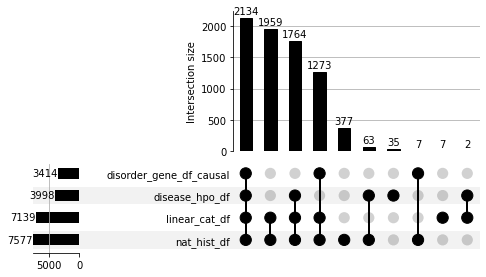

In [18]:
file_memberships = {"disease_hpo_df":set(disease_hpo_df_expanded.OrphaNumber.values),
    "disorder_gene_df_causal":set(disorder_gene_df_causal_expanded.OrphaNumber.values),
    "nat_hist_df":set(nat_hist_df.OrphaNumber.values),
    "linear_cat_df":set(linear_cat_df.OrphaNumber.values)
    }
upset_from_contents = from_contents(file_memberships)
plot_upset(upset_from_contents, show_counts = True,
          sort_by="cardinality")
pyplot.show()

Merge various disorder annotations into one dataframe:

In [19]:
disorder_annotations_merged = disorder_gene_df_causal_expanded.set_index(['OrphaNumber','Disorder_Name']).\
    join(nat_hist_df.set_index(['OrphaNumber','Disorder_Name'])).\
    join(linear_cat_df.set_index(['OrphaNumber','Disorder_Name']))

disorder_annotations_merged = disorder_annotations_merged.reset_index()
disorder_annotations_merged.head(5)

,OrphaNumber,Disorder_Name,Gene_Symbol,Association_Type,Association_Status,Gene_Synonyms,Gene_External_Refs,Onset_Infant,Onset_Child,Onset_Adolescent,Onset_Adult,Onset_Elderly,Disorder_Type,Average_Age_Onset,Average_Age_Death,Inheritence_Types,Category
0,100,Ataxia-telangiectasia,ATM,Disease-causing germline mutation(s) in,Assessed,"TEL1|TEL1, telomere maintenance 1, homolog (S....",SwissProt:Q13315|Ensembl:ENSG00000149311|Genat...,True,True,False,False,False,Disease,Childhood|Infancy,adult,Autosomal recessive,Rare neurologic disease
1,100006,"ABeta amyloidosis, Dutch type",APP,Disease-causing germline mutation(s) in,Assessed,peptidase nexin-II,Ensembl:ENSG00000142192|Genatlas:APP|HGNC:620|...,False,False,False,True,False,Clinical subtype,Adult,adult,Autosomal dominant,Rare neurologic disease
2,100008,ACys amyloidosis,CST3,Disease-causing germline mutation(s) in,Assessed,,Ensembl:ENSG00000101439|Genatlas:CST3|HGNC:247...,False,False,True,True,False,Clinical subtype,Adolescent|Adult,adult,Autosomal dominant,Rare neurologic disease
3,100031,Hypoplastic amelogenesis imperfecta,ACP4,Disease-causing germline mutation(s) (loss of ...,Assessed,testicular acid phosphatase,SwissProt:Q9BZG2|OMIM:606362|HGNC:14376|Ensemb...,False,False,False,False,False,Clinical subtype,,,Autosomal dominant|Autosomal recessive|X-linke...,Rare odontologic disease
4,100031,Hypoplastic amelogenesis imperfecta,RELT,Disease-causing germline mutation(s) (loss of ...,Assessed,FLJ14993|receptor expressed in lymphoid tissues,HGNC:13764|Ensembl:ENSG00000054967|SwissProt:Q...,False,False,False,False,False,Clinical subtype,,,Autosomal dominant|Autosomal recessive|X-linke...,Rare odontologic disease


Subset the dataframes down to the final list of diseases that have all the information we plan to require:

In [20]:
orphanumbers_w_phenotypes = set(disease_hpo_df_expanded.OrphaNumber.unique())
orphanet_all_annotations_diseases_w_phenotypes = disorder_annotations_merged.query("OrphaNumber in @orphanumbers_w_phenotypes")

orphanet_final_disease_genes = orphanet_all_annotations_diseases_w_phenotypes[["OrphaNumber", "Disorder_Name", 'Gene_Symbol']].\
                            drop_duplicates()
final_diseases = orphanet_final_disease_genes.OrphaNumber.unique()

orphanet_final_disease_metadata = orphanet_all_annotations_diseases_w_phenotypes[["OrphaNumber", "Disorder_Name",
                                                "Onset_Infant", "Onset_Child",
                                                "Onset_Adolescent","Onset_Adult","Onset_Elderly",
                                               "Average_Age_Onset","Average_Age_Death","Inheritence_Types","Category"]].\
                            drop_duplicates()
    
orphanet_final_disease_hpo = disease_hpo_df_expanded.query("OrphaNumber in @final_diseases")

assert(orphanet_final_disease_genes.OrphaNumber.unique().sort() == orphanet_final_disease_hpo.OrphaNumber.unique().sort())
assert(orphanet_final_disease_metadata.OrphaNumber.unique().sort() == orphanet_final_disease_hpo.OrphaNumber.unique().sort())

# Annotating diseases and genes as pre- versus post-2015

We used a semi-automated approach to identify novel genes and diseases post-2015.

First, we compared timestamped versions of the OrphaNet dataset to identify candidate novel genes and diseases, as documented in this code.

Each of these was then manually reviewed into spreadhseets that we provide in the `manual_annotations` subdirectory of the `orphanet` data folder.

Finally, we reimported these manual annotations back into this notebook for final processing.

## New Diseases

### Automated step -- import 2015 linearization and compare to 2019 version

In [21]:
tree = ET.parse(str(config.ORPHANET_PATH / 'raw_files_2015_03'/ "linearization_en_product7.xml"))
root = tree.getroot()
disorderlist_cross_2015 = root[0]

rel_list_2015 = []
for disorder in disorderlist_cross_2015:
    disorder_orphan = disorder.find("orphanumber").text
    disorder_name = disorder.find("name").text
    rel_list_2015.append(OrderedDict([
            ("OrphaNumber", disorder_orphan),
            ("Disorder_Name", disorder_name)
        ]))
rel_df_2015 = pd.DataFrame(rel_list_2015)
print(len(rel_df_2015.OrphaNumber.unique()))
rel_df_2015.head()

9142


,OrphaNumber,Disorder_Name
0,166024,"Multiple epiphyseal dysplasia, Al-Gazali type"
1,58,Alexander disease
2,166032,"Multiple epiphyseal dysplasia, with miniepiphyses"
3,61,Alpha-mannosidosis
4,166029,"Multiple epiphyseal dysplasia, with severe pro..."


In [22]:
orphanet_final_disease_metadata["In_2015"] = [x in rel_df_2015.OrphaNumber.values for x in orphanet_final_disease_metadata.OrphaNumber.values ]

### Post-manual step -- annotate diseases first published post 2015

In [23]:
disease_dates_manual = pd.read_csv(config.ORPHANET_PATH / 'manual_annotations' / 'Orphanet_Diseases_Annotation-new_disease_post_2015.tsv', sep="\t", dtype=str)

orpha_ids_post_2015 = disease_dates_manual.query("Date_First_Paper >= '1/1/2015'").OrphaNumber.values
orphas_boolean_post_2015 = [onum in orpha_ids_post_2015 for onum in orphanet_final_disease_metadata.OrphaNumber.values]
orphas_boolean_pre_2015 = [(onum not in orpha_ids_post_2015) for onum in orphanet_final_disease_metadata.OrphaNumber.values]

orphanet_final_disease_metadata["First_Published_post_2015_01"] = orphas_boolean_post_2015

orphas_in_2015 = orphanet_final_disease_metadata.query("not First_Published_post_2015_01").OrphaNumber.values
disease_counts = orphanet_final_disease_genes.query("OrphaNumber in @ orphas_in_2015").groupby("Gene_Symbol").count().OrphaNumber

## New genes

### Automated step -- import 2015 orphadata

The easiest way for us to access 2015 orphadata for gene-level annotations was via an export from the HPOA.

In [24]:
gene_df_2015 = pd.read_csv(str(config.ORPHANET_PATH / 'flat_files_2015_01'/ 'hpoa_orpha_gene_disease.tsv'),
                           delimiter='\t')
gene_df_2015['OrphaNumber'] = [x.split(":")[1] for x in gene_df_2015.OrphaNumber.values]

Additionally, import 2012 data from OrphaData dump to supplement the HPOA export, because we noticed the latter was clearly incomplete.  (Recall, the primary goal of this automated step is to *rule-out any disease-gene links that we know* are not novel, so that we can focus manual efforts.)

In [25]:
import xml.etree.ElementTree as ET
tree = ET.parse(str(config.ORPHANET_PATH / 'raw_files_2012_06'/ "genes_rare_diseases_en_product6.xml"))
root = tree.getroot()
genelist_2012 = root[0]

import pandas as pd
from collections import OrderedDict
gene_list_2012 = []
for disorder in genelist_2012:
    disorder_orphan = disorder.find("orphanumber").text
    disorder_name = disorder.find("name").text
    for child_gene in disorder.find("genelist"):
        gene_symbol = child_gene.find("symbol").text
        gene_synonyms = "|".join([x.text
                                  for x in child_gene.find("synonymlist")])
        external_refs = "|".join([":".join([x.find("source").text, x.find("reference").text])
                                  for x in child_gene.find("externalreferencelist")])
        gene_list_2012.append(OrderedDict([
            ("OrphaNumber", disorder_orphan),
            ("Disorder_Name", disorder_name),
            ("Gene_Symbol", gene_symbol),
            ("Gene_Synonyms", gene_synonyms),
            ("Gene_External_Refs", external_refs)
        ]))
gene_df_2012 = pd.DataFrame(gene_list_2012)
#print(len(gene_df_2012.OrphaNumber.unique()))
#gene_df_2012.to_csv(ORPHANET_PATH / 'flat_files_2012_06'/ 'orphanet_disease_gene_all_unfiltered.tsv',
#                    sep="\t", index = False)

Add confirmed former annotations to metadata file:

In [26]:
d_g_2015_all = list(zip(gene_df_2015.OrphaNumber.values,
                        gene_df_2015.Gene_Symbol.values))

d_g_2012_all = list(zip(gene_df_2012.OrphaNumber.values,
                        gene_df_2012.Gene_Symbol.values))
d_g_2019_all = list(zip(orphanet_final_disease_genes.OrphaNumber.values,
                        orphanet_final_disease_genes.Gene_Symbol.values))

orphanet_final_disease_genes['DG_Association_In_Orpha_2012_06'] = [(d_g in d_g_2012_all) for d_g in d_g_2019_all ]
orphanet_final_disease_genes['DG_Association_In_Orpha_2015_01'] = [(d_g in d_g_2015_all) for d_g in d_g_2019_all ]

Visualize:

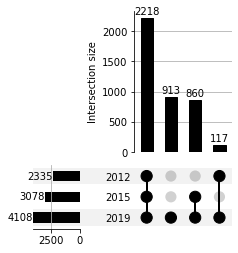

In [27]:
file_memberships = {"2019":set(orphanet_final_disease_genes.apply(lambda row: (row["OrphaNumber"], row["Gene_Symbol"]), axis=1) ),
                    "2015":set(orphanet_final_disease_genes.query("DG_Association_In_Orpha_2015_01").apply(lambda row: (row["OrphaNumber"], row["Gene_Symbol"]), axis=1) ),
                    "2012":set(orphanet_final_disease_genes.query("DG_Association_In_Orpha_2012_06").apply(lambda row: (row["OrphaNumber"], row["Gene_Symbol"]), axis=1) )
                    
    }
upset_from_contents = from_contents(file_memberships)
plot_upset(upset_from_contents, show_counts = True,
          sort_by="cardinality")
pyplot.show()

Sanity check:

In [28]:
gene_counts_2019 = orphanet_final_disease_genes.groupby("OrphaNumber").count().Gene_Symbol
assert(sum(orphanet_final_disease_metadata.OrphaNumber.values != gene_counts_2019.index) == 0)
orphanet_final_disease_metadata['N_Genes'] = gene_counts_2019.values

### Post-manual step

Import annotations:

In [29]:
new_genes_known_diseases_dates = pd.read_csv(config.ORPHANET_PATH / 'manual_annotations' / 'Orphanet_Genes_Annotation-NG_KG_post_2015.tsv', sep="\t", dtype=str)

curated_new_genes_delete = list(map(tuple, new_genes_known_diseases_dates.query('Date_First_Paper == "DELETE"')[['OrphaNumber','Gene_Symbol']].values.tolist()))
new_genes_known_diseases_dates = new_genes_known_diseases_dates.query('Date_First_Paper != "DELETE"')

new_genes_known_diseases_dates['Date_First_Paper'] = pd.to_datetime(new_genes_known_diseases_dates['Date_First_Paper'], errors = 'coerce')
new_genes_known_diseases_dates.head()

,OrphaNumber,Disorder_Name,Gene_Symbol,Date_First_Paper,Source,Notes,Annotator
3,93110,Posterior urethral valve,BNC2,2019-05-02,https://www.ncbi.nlm.nih.gov/pubmed/31051115,NaN,Michelle
4,2662,Keipert syndrome,GPC4,2019-04-11,https://www.ncbi.nlm.nih.gov/pubmed/30982611,New Orphanet Number 301026 (Moved as of June 2...,Michelle
5,2754,Orofaciodigital syndrome type 6,FAM149B1,2019-04-04,https://www.sciencedirect.com/science/article/...,NaN,Emily
6,29072,Hereditary pheochromocytoma-paraganglioma,DLST,2019-03-28,https://www.ncbi.nlm.nih.gov/pubmed/30929736,NaN,Michelle
7,178469,Autosomal dominant non-syndromic intellectual ...,BRSK2,2019-03-14,https://www.ncbi.nlm.nih.gov/pubmed/30879638,NaN,Sam


Binarize pre-post 2015 date information:

In [30]:
curated_new_genes = list(map(tuple, new_genes_known_diseases_dates.query("Date_First_Paper >= '1/1/2015'")[['OrphaNumber','Gene_Symbol']].values.tolist()))
curated_old_genes = list(map(tuple, new_genes_known_diseases_dates.query("Date_First_Paper < '1/1/2015'")[['OrphaNumber','Gene_Symbol']].values.tolist()))

final_dis_gene_edges = list(map(tuple, orphanet_final_disease_genes[['OrphaNumber','Gene_Symbol']].values.tolist()))

def computeDateRange(tup):
    if tup in curated_new_genes:
        return "post_2015_03_01"
    elif tup in curated_old_genes:
        return "pre_2015_03_01"
    elif tup in curated_new_genes_delete:
        return "DELETE"
    else:
        return None
    
curated_date_ranges = [computeDateRange(tup) for tup in final_dis_gene_edges]

orphanet_final_disease_genes["Manual_Annotation_Date_Range"] = curated_date_ranges
orphanet_final_disease_genes = orphanet_final_disease_genes.query("Manual_Annotation_Date_Range != 'DELETE'")
orphanet_final_disease_genes.Manual_Annotation_Date_Range.value_counts()

post_2015_03_01    431
pre_2015_03_01     274
Name: Manual_Annotation_Date_Range, dtype: int64

Finalize annotation formats in files to be exported:

In [31]:
orphanet_final_gene_metadata = pd.DataFrame(list(set(orphanet_final_disease_genes.Gene_Symbol)), columns=["Gene_Symbol"])
orphanet_final_gene_metadata['Gene_In_Any_Orpha_Disease_2015_03'] = [(gene in gene_df_2015.Gene_Symbol.values) or (gene in gene_df_2012.Gene_Symbol.values) for gene in orphanet_final_gene_metadata.Gene_Symbol.values]

In [32]:
orphanet_final_disease_genes['DG_Assoc_First_Published_Post_2015_01'] = ~orphanet_final_disease_genes['DG_Association_In_Orpha_2015_01']

orphanet_final_disease_genes.loc[orphanet_final_disease_genes['Manual_Annotation_Date_Range'] == 'post_2015_03_01', 'DG_Assoc_First_Published_Post_2015_01'] = True 
orphanet_final_disease_genes.loc[orphanet_final_disease_genes['Manual_Annotation_Date_Range'] == 'pre_2015_03_01', 'DG_Assoc_First_Published_Post_2015_01'] = False 

orphanet_final_disease_genes.drop(columns=["DG_Association_In_Orpha_2012_06","DG_Association_In_Orpha_2015_01", 'Manual_Annotation_Date_Range'], inplace=True)

# Save